<a href="https://colab.research.google.com/github/KTada777/Bayesian_SolarCell_1D-Citrcuit/blob/main/251008_pymc5%2Bnutpie_PVparameter_demo_TadaJJAP_10k_10k(UpTo0_9V).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!cat /proc/cpuinfo | awk '/processor/,/cpu MHz/'

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0xffffffff
cpu MHz		: 2199.998
processor	: 1
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0xffffffff
cpu MHz		: 2199.998


In [2]:
import sys
print(sys.version)

3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]


In [3]:
!pip install nutpie

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 4.6 MB/s eta 0:00:00


In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
#
import numpy as np
#
import pymc as pm
import arviz as az
import time
#
import pytensor
pytensor.config.optdb__max_use_ratio = 40
#
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
#
import nutpie
#
print(pm.__version__)

5.25.1


In [5]:
def pm_I_Roberts_g(Iph, Rp, Rs, I0, n, V):
    Iph = Iph / 1000  #mA
    Rs = Rs / 1e3     #mOhm
    I0 = I0 / 1e9     #nA
    nVt = n*0.026    #Vt(RT)=26 mV
    x = np.log(I0 * (Rs * Rp) / (Rs + Rp) / nVt) + (Rp / (Rs + Rp)) * (V + Rs * (I0 + Iph)) / nVt

    return (V - nVt * (pm_Roberts_g(x) - np.log(I0 * Rs * Rp / (Rs + Rp) / nVt))) / Rs

In [6]:
def pm_Roberts_g(x):
    e_1 = np.exp(-1)
    e1 = np.exp(1)
    g = pm.math.switch((x <= -(e_1)), x, pm.math.switch((x >= e1), np.log(x), -e1 + (1 + e1) / (2 * e1) * (x + e1)))
#
    eg = np.exp(g)
    g = g - (2 * (g + eg - x) * (1 + eg)) / (2 * (1 + eg) ** 2 - (g + eg - x) * eg)
#
    eg = np.exp(g)
    g = g - (2 * (g + eg - x) * (1 + eg)) / (2 * (1 + eg) ** 2 - (g + eg - x) * eg)
#
    eg = np.exp(g)
    g = g - (2 * (g + eg - x) * (1 + eg)) / (2 * (1 + eg) ** 2 - (g + eg - x) * eg)
#
    eg = np.exp(g)
    g = g - (2 * (g + eg - x) * (1 + eg)) / (2 * (1 + eg) ** 2 - (g + eg - x) * eg)
#
    return g

In [7]:
#
# I-V of PTB7-Th:C70 OPV from K. Tada, Jpn. J. Appl. Phys. 59 (2020) SDDD03.
#
X = np.array([0.8,       0.789999,  0.78,      0.769999,
  0.76,      0.75,      0.74,      0.73,      0.72,      0.71,      0.699999,
  0.69,      0.679999,  0.67,      0.66,      0.65,      0.639999,  0.63,
  0.62,      0.609999,  0.599999,  0.59,      0.579999,  0.569999,  0.559999,
  0.55,      0.54,      0.529999,  0.519999,  0.51,      0.5,       0.49,
  0.479999,  0.469999,  0.46,      0.449999,  0.44,      0.43,      0.42,
  0.409999,  0.4,       0.389999,  0.379999,  0.37,      0.359999,  0.35,
  0.339999,  0.329999, 0.319999,  0.309999,  0.3,       0.289999,  0.28,
  0.269999, 0.26,      0.249999,  0.239999, 0.229999,  0.22,      0.21,
  0.2,       0.189999,  0.18,      0.169999,  0.16,      0.15,     0.14,
  0.13,      0.119999,  0.11,      0.1,       0.089999,  0.08,      0.069999,
  0.059999,  0.049999,  0.039999,  0.029999,  0.019999,  0.01,      0.,
  0.,       -0.010001, -0.020001, -0.03,     -0.040001, -0.05,     -0.060001,
 -0.070001, -0.08,     -0.09,     -0.1,      -0.11,     -0.12,     -0.130001,
 -0.14,     -0.15,     -0.16,     -0.17,     -0.180001, -0.190001, -0.200001])
#
Y = np.array([0.00483389,  0.00395378,
  0.00308822,  0.00223744,  0.00140311,  0.00058722, -0.00021056, -0.00098933,
 -0.00174567, -0.00248111, -0.00318922, -0.00387656, -0.00453244, -0.00515689,
 -0.00575567, -0.00632133, -0.00685089, -0.00734844, -0.00781567, -0.00824656,
 -0.00864278, -0.00900667, -0.00934922, -0.00965233, -0.00993933, -0.01019733,
 -0.01043011, -0.01064567, -0.01083911, -0.01102767, -0.01119033, -0.01135111,
 -0.01150278, -0.01162522, -0.01175878, -0.01187333, -0.01197889, -0.01208922,
 -0.01218344, -0.01227211, -0.01235933, -0.01244244, -0.01251644, -0.01259311,
 -0.01265978, -0.01273578, -0.01280322, -0.01286378, -0.01291811, -0.01297756,
 -0.01303,    -0.01308089, -0.01313456, -0.01318144, -0.013228,   -0.013278,
 -0.01331756, -0.01336178, -0.01340311, -0.013444,   -0.01348533, -0.01351011,
 -0.013559,   -0.013578,   -0.013627,   -0.01366011, -0.01369278, -0.01372567,
 -0.01375267, -0.01377267, -0.01380744, -0.01383822, -0.01386133, -0.01388511,
 -0.01391056, -0.01393422, -0.01396856, -0.013999,   -0.01402278, -0.01404078,
 -0.01405433, -0.01405944, -0.01407756, -0.01409489, -0.01412244, -0.01413767,
 -0.01415433, -0.01418433, -0.01419467, -0.01422011, -0.01424022, -0.01426411,
 -0.01427633, -0.01430433, -0.01431522, -0.01433156, -0.01436233, -0.01437111,
 -0.01438489, -0.01440544, -0.01440667, -0.01443411])

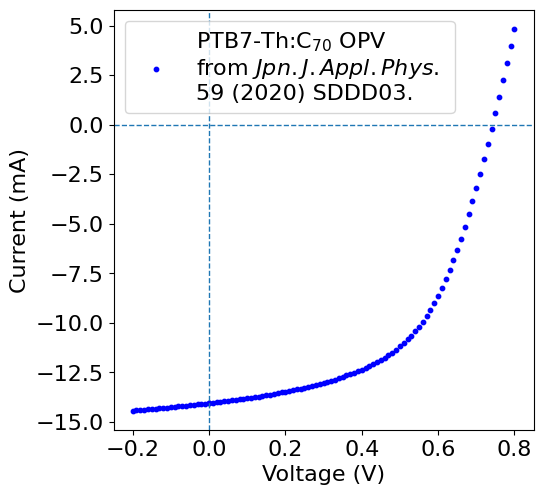

In [8]:
######################################
plt.rcParams['font.size'] = 16
#
fig = plt.figure( figsize=(6,6) )
fig.subplots_adjust(left=0.22, right=0.92,
                    top=0.9, bottom=0.2)
#
ax1 = fig.add_subplot(1,1,1)
ax1.set_xlabel('Voltage (V)')
ax1.set_ylabel('Current (mA)')
#
ax1.scatter(X, Y*1e3, color='blue',
            s=10.0,
            label='PTB7-Th:C$_{70}$ OPV \nfrom $Jpn. J. Appl. Phys.$ \n59 (2020) SDDD03.'
           )
#
(x_left, x_right) = ax1.set_xlim()
(y_bot, y_top) = ax1.set_ylim()
#
ax1.hlines(0, x_left, x_right,
           linestyles='dashed', linewidth=1.0)
ax1.vlines(0, y_bot, y_top,
           linestyles='dashed', linewidth=1.0)
#
#plt.title( r'Int. J. Sol. Ener. Cell' )
plt.legend()

In [9]:
#
t0 = time.perf_counter()
#
with pm.Model() as model:
    Iph = pm.Uniform('Iph', lower=1e-2, upper=1e4 )  #mA
    Rp = pm.Uniform('Rp', lower=1e0, upper=1e5)      #Ohm
    Rs = pm.Uniform('Rs', lower=1e0, upper=1e8 )     #mOhm
    I0 = pm.Uniform('I0', lower=1e-1, upper=1e6 )    #nA
    n = pm.Uniform('n', lower=0.5, upper=500 )       #Vt(RT)=26 mV
#
    rmsd = pm.Uniform('rmsd', lower=0, upper=1e-2)
    mu = pm_I_Roberts_g(Iph, Rp, Rs, I0, n, X)
#
    y = pm.Normal('y', mu=mu, sigma=rmsd, observed=Y)
#
    trace_nutpie = pm.sample(10000, tune=10000, chains=2, cores=2, target_accept=0.99, nuts_sampler='nutpie')
#
t1 = time.perf_counter()
print( "elapsed time %.3f sec" % (t1-t0)  )

Progress,Draws,Divergences,Step Size,Gradients/Draw
,20000,0,0.03,447
,20000,0,0.04,319


elapsed time 745.870 sec


In [10]:
def Roberts_g(x):
    if x <= -(np.exp(-1)):
        g = x
    elif x >= (np.exp(1)):
        g = np.log(x)
    else:
        g = -np.exp(1) + (1 + np.exp(1)) / (2 * np.exp(1)) * (x + np.exp(1))
#
    eg = np.exp(g)
    g = g - (2 * (g + eg - x) * (1 + eg)) / (2 * (1 + eg) ** 2 - (g + eg - x) * eg)
#
    eg = np.exp(g)
    g = g - (2 * (g + eg - x) * (1 + eg)) / (2 * (1 + eg) ** 2 - (g + eg - x) * eg)
#
    eg = np.exp(g)
    g = g - (2 * (g + eg - x) * (1 + eg)) / (2 * (1 + eg) ** 2 - (g + eg - x) * eg)
#
    eg = np.exp(g)
    g = g - (2 * (g + eg - x) * (1 + eg)) / (2 * (1 + eg) ** 2 - (g + eg - x) * eg)
#
    return g

In [11]:
def I_Roberts_g(Iph, Rp, Rs, I0, n, V):
    Iph = Iph / 1000  #mA
    Rs = Rs / 1e3     #mOhm
    I0 = I0 / 1e9     #nA
    nVt = n*0.026     #Vt(RT)=26 mV
    LogQ = np.log(I0 * (Rs * Rp) / (Rs + Rp) / nVt) + (Rp / (Rs + Rp)) * (V + Rs * (I0 + Iph)) / nVt
    return (V - nVt * (Roberts_g(LogQ) - np.log(I0 * Rs * Rp / (Rs + Rp) / nVt))) / Rs

In [12]:
def calcI(Iph, Rp, Rs, I0, n, V):
    V_list = V.tolist()
    I_list = [I_Roberts_g(Iph, Rp, Rs, I0, n, item) for item in V_list]
    return np.array(I_list)

In [13]:
az.summary(trace_nutpie)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
I0,2532.497,532.340,1615.227,3537.566,13.349,14.470,1679.0,1962.0,1.0
I0_interval__,-5.998,0.209,-6.377,-5.609,0.005,0.004,1679.0,1962.0,1.0
Iph,14.216,0.016,14.186,14.247,0.000,0.000,3284.0,4161.0,1.0
Iph_interval__,-6.555,0.001,-6.557,-6.553,0.000,0.000,3284.0,4161.0,1.0
Rp,371.832,11.047,351.886,392.816,0.229,0.192,2395.0,3297.0,1.0
Rp_interval__,-5.594,0.030,-5.649,-5.538,0.001,0.000,2395.0,3297.0,1.0
Rs,5292.650,197.064,4919.210,5653.958,4.621,3.760,1846.0,2227.0,1.0
Rs_interval__,-9.847,0.037,-9.917,-9.778,0.001,0.001,1846.0,2227.0,1.0
n,3.367,0.082,3.222,3.523,0.002,0.002,1680.0,1974.0,1.0
n_interval__,-5.155,0.029,-5.207,-5.101,0.001,0.001,1680.0,1974.0,1.0


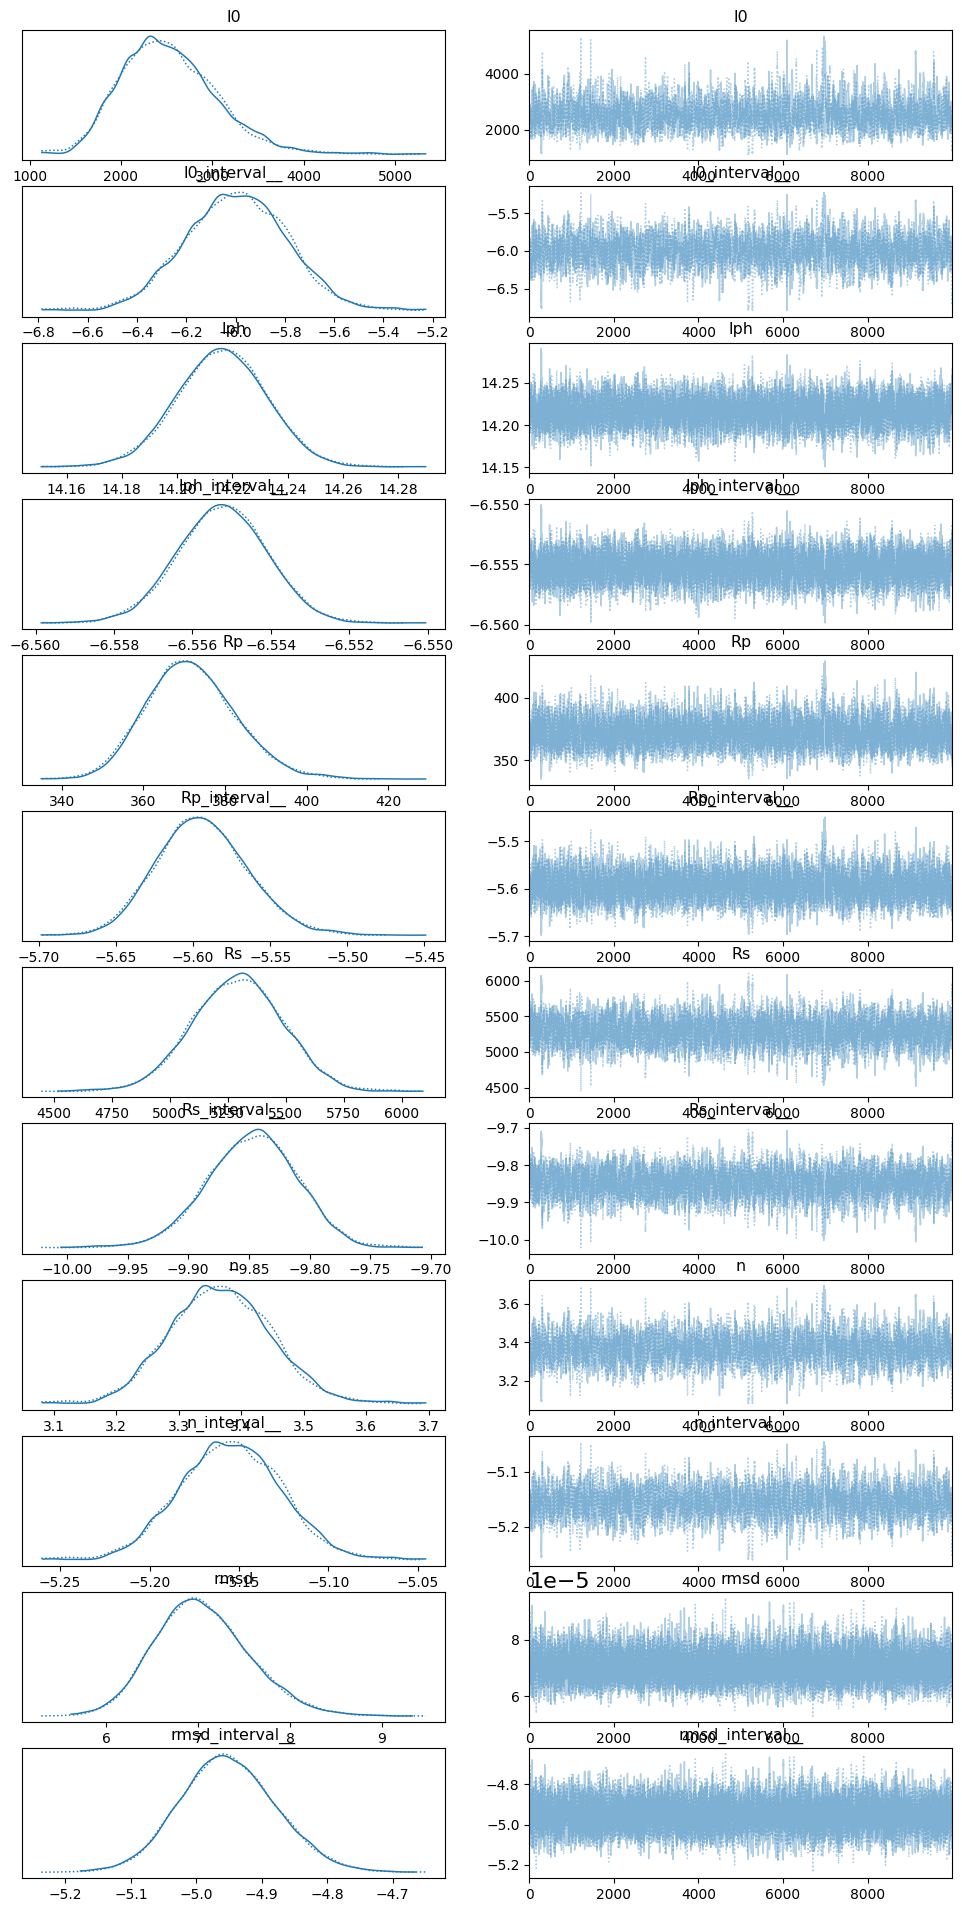

In [14]:
with model:
  az.plot_trace(trace_nutpie)

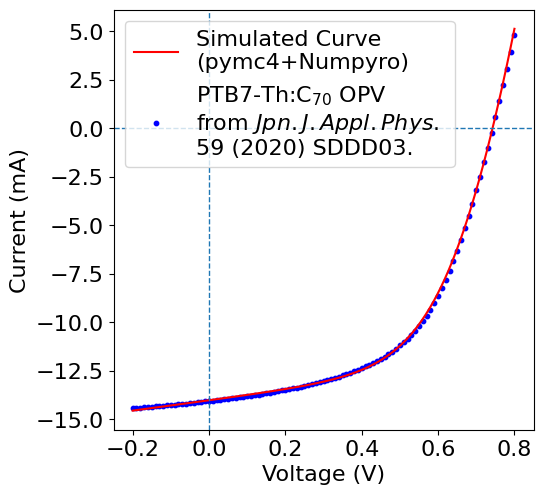

In [15]:
######################################
plt.rcParams['font.size'] = 16
#
fig = plt.figure( figsize=(6,6) )
fig.subplots_adjust(left=0.22, right=0.92,
                    top=0.9, bottom=0.2)
#
ax1 = fig.add_subplot(1,1,1)
ax1.set_xlabel('Voltage (V)')
ax1.set_ylabel('Current (mA)')
#
ax1.scatter(X, Y*1e3, color='blue',
            s=10.0,
            label='PTB7-Th:C$_{70}$ OPV \nfrom $Jpn. J. Appl. Phys.$ \n59 (2020) SDDD03.'
           )

xmin = np.amin(X)
xmax = np.amax(X)
N = 100
X_range = np.linspace(xmin, xmax, num=N, endpoint=True )

Q = az.summary(trace_nutpie)
Iph_m = Q.loc['Iph','mean']
Rp_m = Q.loc['Rp','mean']
Rs_m = Q.loc['Rs','mean']
I0_m = Q.loc['I0','mean']
n_m = Q.loc['n','mean']
I_list = calcI(Iph_m, Rp_m, Rs_m, I0_m, n_m, X_range)

ax1.plot(X_range, I_list*1e3, color='red',
            label='Simulated Curve\n(pymc4+Numpyro)'
           )

#
(x_left, x_right) = ax1.set_xlim()
(y_bot, y_top) = ax1.set_ylim()
#
ax1.hlines(0, x_left, x_right,
           linestyles='dashed', linewidth=1.0)
ax1.vlines(0, y_bot, y_top,
           linestyles='dashed', linewidth=1.0)
#
handles, labels = ax1.get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1])